# Load

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
from anndata import AnnData
from scipy.sparse import diags
from scipy.io import mmwrite
from scipy import sparse
from scipy.optimize import fsolve,minimize
from tqdm import tqdm
from pathlib import Path
from typing import Union, Optional
import pickle
import seaborn as sns

In [3]:
from scDenorm.denorm import *

In [4]:
from scAnnot.tools import *

In [5]:
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib as mpl
sc.set_figure_params(scanpy=True, fontsize=14,facecolor=None,frameon=False,transparent=True)
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.grid'] = False

mpl.rcParams['pdf.fonttype']=42
mpl.rcParams['ps.fonttype']=42

mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "Arial"

In [6]:
def solve_bc(p,y1,y2):
    return sum((np.exp(y2*np.log(p[0]))-2*np.exp(y1*np.log(p[0]))+p[1])**2)

In [7]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

def fit_nb(ms):
    
    def nb_func(x, phi):
        return x[0] + (phi * x[0] ** 2)
    
    popt, _ = curve_fit(nb_func, ms['mean'], ms['var'], p0=[1])
    phi = popt[0]
    
    ms['zeros_p'] = np.exp(-ms['mean'])
    ms['zeros_nb'] = (1 + phi * ms['mean']) ** (-1 / phi)
    ms['newVar'] = ms['mean'] + phi * ms['mean'] ** 2
    return ms

In [47]:
def plot_mv(cmean,cvar,x_ticks,y_ticks,c='blue',log=True,fit=False,save=None):
    fig, ax = plt.subplots()
    if log:
        ax.loglog()
    #ax.set_xscale('log') 
    ax.scatter(cmean, cvar,s=20,c=c)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    ax.set_aspect('equal')
    #ax.tick_params(axis='both', which='major', labelsize=15)
    #ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel('Mean (genes)')#,fontsize=18)
    ax.set_ylabel('Variance (genes)')#,fontsize=18)
    ax.set_xticks(x_ticks)
    #ax.set_xticklabels(x_ticks)

    ax.set_yticks(y_ticks)
    #ax.set_yticklabels(y_ticks)
    ax.plot(lims, lims, linestyle='--', linewidth=2, alpha=0.75, color='#4C72B0', label='line')
    if fit:
        ms=pd.DataFrame({'mean':cmean[0],'var':cvar[0]})
        ms=fit_nb(ms)
        ms=ms.sort_values('mean')
        plt.plot(ms['mean'],ms['newVar'],'k-', alpha=1,linewidth=2, zorder=ms.shape[0],color='#DD8452', label='line')
    if save:
        plt.savefig(save,dpi=300, bbox_inches='tight',transparent=True,format='pdf')

## Real data with raw and normalized

In [48]:
ad=sc.read('/home/huang_ziliang/project/brain/data/public/human_brain_source_Velmeshev_2019/h5/brain_source_Velmeshev_2019.h5')

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [49]:
ad

AnnData object with n_obs × n_vars = 104559 × 65217
    obs: 'cluster', 'sample', 'individual', 'region', 'age', 'sex', 'diagnosis', 'Capbatch', 'Seqbatch', 'post-mortem interval (hours)', 'RNA Integrity Number', 'genes', 'UMIs', 'RNA mitochondr. percent', 'RNA ribosomal percent'
    var: 'gene_ids'

In [50]:
ad.X.data

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [51]:
smtx = ad.copy().X.tocsr().asfptype()
sc.pp.normalize_total(ad, target_sum=1e4)
smtx1 = ad.copy().X.tocsr().asfptype()

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_105349/57921094.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(ms['mean'],ms['newVar'],'k-', alpha=1,linewidth=2, zorder=ms.shape[0],color='#DD8452', label='line')


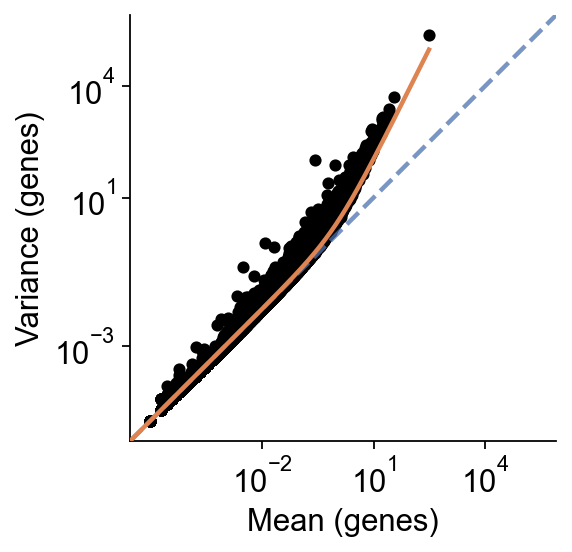

In [53]:
figsize(3.5,3.5)
cmean = np.array(smtx.mean(0))
cvar = np.array(smtx.power(2).mean(0) - cmean ** 2)
#A
plot_mv(cmean,cvar,x_ticks=[0.01,10,10000],y_ticks=[0.001,10,10000],c='black',fit=True,save='figures/mvsv_count.pdf')

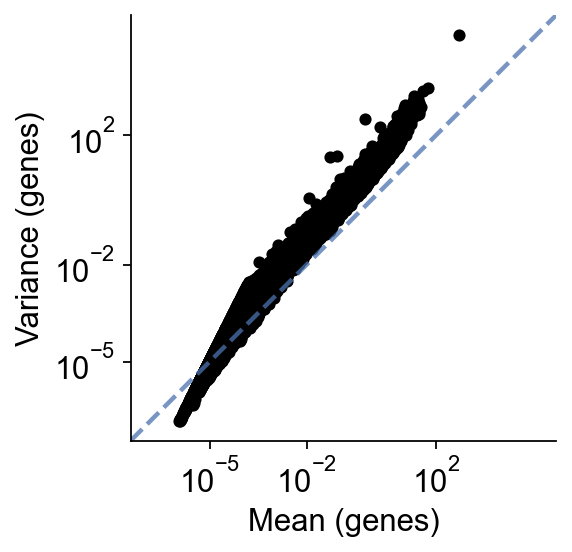

In [55]:
cmean = np.array(smtx1.mean(0))
cvar = np.array(smtx1.power(2).mean(0) - cmean ** 2)
#A
plot_mv(cmean,cvar,x_ticks=[0.00001,0.01,100],y_ticks=[0.00001,0.01,100],c='black',fit=False,log=True,save='figures/mvsv_expr.pdf')

In [63]:
import gzip
import csv

genes,rows=[],[]
with gzip.open('/home/huang_ziliang/project/brain/data/public/human_brain_source_Velmeshev_2019/exprMatrix.tsv.gz', 'rt') as file:
    reader = csv.reader(file, delimiter='\t')
    for row in reader:
        genes.append(row[0])
        try:
            rows.append([float(i) for i in row[1:1001]])
        except:
            cells=row[1:1001]
            print(row[0])

gene_ID


In [64]:
import numpy as np
from scipy.sparse import csr_matrix

In [65]:
smtx=np.array(rows)
smtx=smtx.T 
smtx = csr_matrix(smtx)
smtx.eliminate_zeros() 
smtx.shape

(1000, 36501)

About half of genes are filtered!!!

In [66]:
ad.var['gene_name']=list(ad.var.index)
ad.var.index=list(ad.var.gene_ids)

In [67]:
ad=ad[cells,[i.split('|')[0] for i in genes[1:]]]

In [68]:
ad.layers['expr']=smtx

/tmp/ipykernel_105349/1242020057.py:1: ImplicitModificationWarning: Setting element `.layers['expr']` of view, initializing view as actual.
  ad.layers['expr']=smtx


In [ ]:
ad.layers['counts']=ad.X.copy()

In [ ]:
ad.write_h5ad('data/realdata/human_brain_source_Velmeshev_2019_first1000.h5ad')

## norm

In [79]:
ad=sc.read('results/human_brain_source_Velmeshev_2019_first1000.h5ad')

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [80]:
ad.X=ad.layers['counts'].copy()

In [81]:
ad.layers['expr']

<1000x36501 sparse matrix of type '<class 'numpy.float64'>'
	with 2173216 stored elements in Compressed Sparse Row format>

In [82]:
smtx2 = ad.layers['expr']

In [83]:
smtx2

<1000x36501 sparse matrix of type '<class 'numpy.float64'>'
	with 2173216 stored elements in Compressed Sparse Row format>

In [84]:
smtx2.data

array([3.76158464, 3.76158464, 3.76158464, ..., 3.62652532, 2.73884757,
       3.62652532])

In [27]:
cmap = plt.get_cmap("tab10")

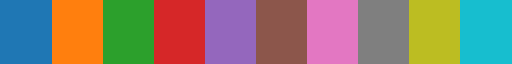

In [28]:
cmap

In [32]:
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
def RCplot1(smtx,xl='Rank of value frequency',yl='Value',xm=None,ym=None,alpha=1,save=None,show_legend=True,fit=False):
    fig, ax = plt.subplots()
        
    c = pd.Series(smtx.getrow(0).data)
    c=c.value_counts().sort_index()
    y = np.array(c.index)
    x = np.arange(0, c.shape[0])+1
    ax.scatter(x, y,alpha=alpha,label=f'Cell {1}',marker='o',s=80,linewidth=1,facecolors='none',edgecolors=cmap(0))
    if fit:
        p = np.polyfit(x[:6], y[:6], 1)
        y_fit = np.polyval(p, np.linspace(0,20,100))
        ax.plot(np.linspace(0,20,100), y_fit,color=cmap(0))
    
    c = pd.Series(smtx.getrow(1).data)
    c=c.value_counts().sort_index()
    y = np.array(c.index)
    x = np.arange(0, c.shape[0])+1
    ax.scatter(x, y,alpha=alpha,label=f'Cell {2}',marker='s',s=40,facecolors=cmap(1),edgecolors='none')
    if fit:
        p = np.polyfit(x[:6], y[:6], 1)
        y_fit = np.polyval(p, np.linspace(0,20,100))
        ax.plot(np.linspace(0,20,100), y_fit,color=cmap(1))
    
    c = pd.Series(smtx.getrow(2).data)
    c=c.value_counts().sort_index()
    y = np.array(c.index)
    x = np.arange(0, c.shape[0])+1
    ax.scatter(x, y,alpha=alpha,label=f'Cell {3}',marker='+',s=40,color=cmap(2))
    if fit:
        p = np.polyfit(x[:6], y[:6], 1)
        y_fit = np.polyval(p, np.linspace(0,20,100))
        ax.plot(np.linspace(0,20,100), y_fit,color=cmap(2))
    

    ax.legend(frameon=False)#,bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(axis='both', which='major')
    ax.tick_params(axis='both', which='minor')
    ax.set_xlabel(xl)
    ax.set_ylabel(yl)
    if not show_legend:
        ax.legend().set_visible(False)
    if ym:
        ax.yaxis.set_major_locator(MaxNLocator(4,integer=True))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
        ax.set_ylim(0, ym)
    if xm:
        ax.set_xlim(0, xm)
    if save:
        plt.savefig(save,dpi=300, bbox_inches='tight',transparent=True,format='pdf')

In [33]:
def RCplot2(smtx,xl='Rank of value frequency',yl='Value',xm=None,ym=None,alpha=1,save=None,show_legend=True,fit=False):
    fig, ax = plt.subplots()
        
    c = pd.Series(smtx.getrow(0).data)
    c=c.value_counts().sort_index()
    y = np.array(c.index)
    x = np.arange(0, c.shape[0])+1
    ax.scatter(x, y,alpha=alpha,label=f'Cell {1}',marker='o',s=80,linewidth=1,facecolors='none',edgecolors=cmap(0))
    if fit:
        ax.plot(np.linspace(0,20,100), np.log2(np.linspace(0,20,100)*(2**y[0]-1)+1),color=cmap(0))
    
    c = pd.Series(smtx.getrow(1).data)
    c=c.value_counts().sort_index()
    y = np.array(c.index)
    x = np.arange(0, c.shape[0])+1
    ax.scatter(x, y,alpha=alpha,label=f'Cell {2}',marker='s',s=40,facecolors=cmap(1),edgecolors='none')
    if fit:
        ax.plot(np.linspace(0,20,100), np.log2(np.linspace(0,20,100)*(2**y[0]-1)+1),color=cmap(1))
    
    c = pd.Series(smtx.getrow(2).data)
    c=c.value_counts().sort_index()
    y = np.array(c.index)
    x = np.arange(0, c.shape[0])+1
    ax.scatter(x, y,alpha=alpha,label=f'Cell {3}',marker='+',s=40,color=cmap(2))
    if fit:
        ax.plot(np.linspace(0,20,100), np.log2(np.linspace(0,20,100)*(2**y[0]-1)+1),color=cmap(2))
    

    ax.legend(frameon=False)#,bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(axis='both', which='major')
    ax.tick_params(axis='both', which='minor')
    ax.set_xlabel(xl)
    ax.set_ylabel(yl)
    ax.set_yticks([0,2.5,5.0,7.5,10.0])
    ax.set_ylim(0, 11)
    if not show_legend:
        ax.legend().set_visible(False)
    if ym:
        ax.yaxis.set_major_locator(MaxNLocator(4,integer=True))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
        ax.set_ylim(0, 11)
    if xm:
        ax.set_xlim(0, xm)
    if save:
        plt.savefig(save,dpi=300, bbox_inches='tight',transparent=True,format='pdf')

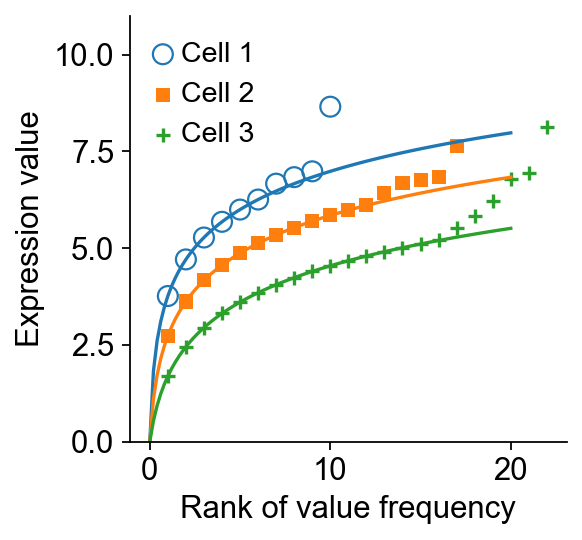

In [34]:
figsize(3.5,3.5)
RCplot2(smtx2,yl='Expression value',fit=True,save='figures/rankvsexpr.pdf')

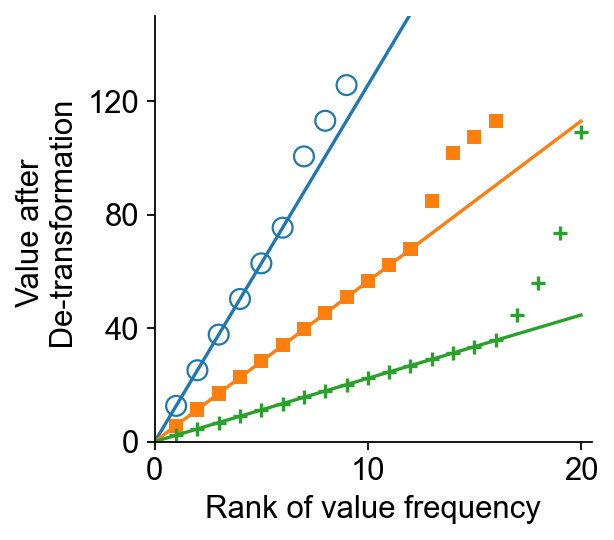

In [35]:
figsize(3.5,3.5)
tmp=smtx2.copy()
tmp.data=2**tmp.data-1
RCplot1(tmp,xm=20.5,ym=150,yl='Value after \n De-transformation',fit=True,show_legend=False,save='figures/rankvsexpr_detransform.pdf')

In [36]:
smtx=scdenorm(ad).X.copy()

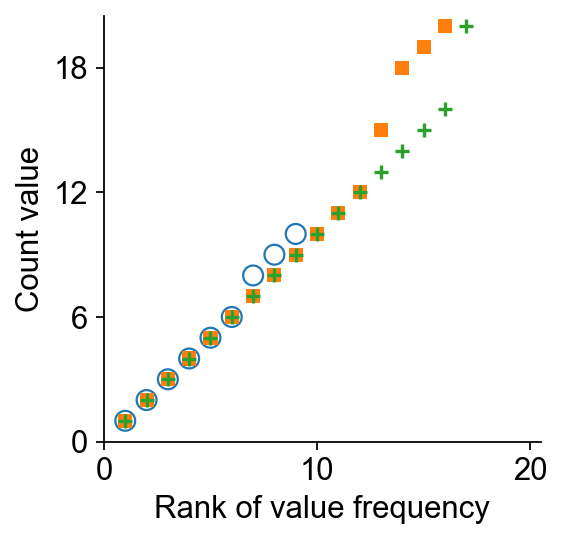

In [37]:
figsize(3.5,3.5)
tmp=smtx.copy()
RCplot1(tmp,xm=20.5,ym=20.5,yl='Count value',show_legend=False,save='figures/rankvscount.pdf')

### M vs V 

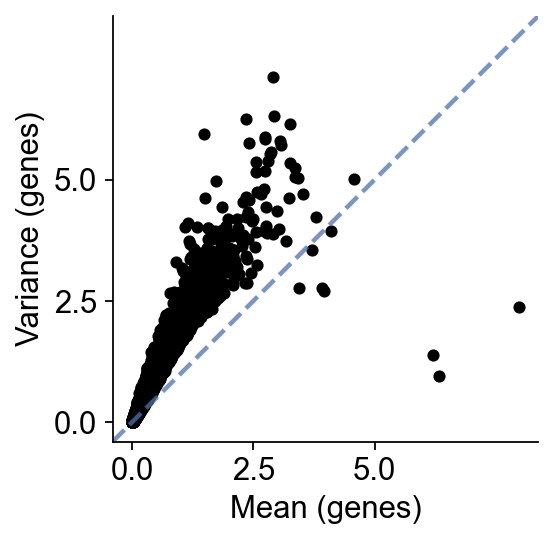

In [72]:
cmean = np.array(smtx2.mean(0))
cvar = np.array(smtx2.power(2).mean(0) - cmean ** 2)
#A
plot_mv(cmean,cvar,x_ticks=[0,2.5,5],y_ticks=[0,2.5,5],c='black',fit=False,log=False)#,save='figures/realdata/mvsv_expr.pdf')

In [60]:
x,y= cmean[0],cvar[0]

In [61]:
y1 = poly1d(polyfit(x,y,2))

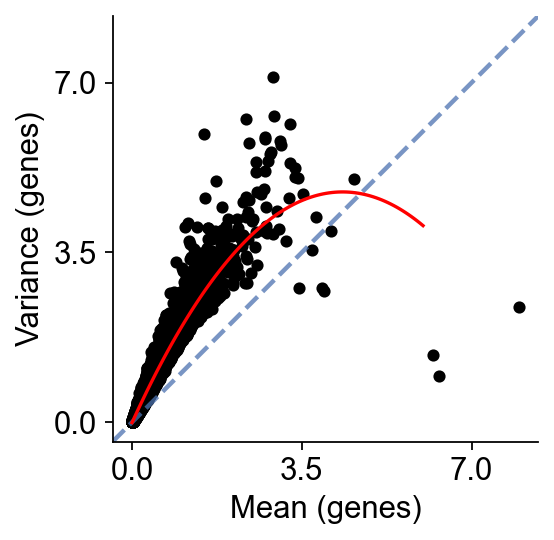

In [75]:
figsize(3.5,3.5)
fig, ax = plt.subplots()
ax.scatter(cmean, cvar,s=20,c='black')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.set_aspect('equal')
#ax.tick_params(axis='both', which='major', labelsize=15)
#ax.tick_params(axis='both', which='minor', labelsize=8)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('Mean (genes)')#,fontsize=18)
ax.set_ylabel('Variance (genes)')#,fontsize=18)
ax.set_xticks([0,3.5,7])
ax.set_yticks([0,3.5,7])
#ax.set_yticklabels(y_ticks)
ax.plot(lims, lims, linestyle='--', linewidth=2, alpha=0.75, color='#4C72B0', label='Diag line')
plt.plot(np.linspace(0,6,100), y1(np.linspace(0,6,100)), color='red', label='Smoothed Curve')
plt.savefig('figures/mv_norm.pdf',dpi=300, bbox_inches='tight',transparent=True,format='pdf')

In [ ]:
def histplot(data,color,xl='Value',yl='Frequency',save=None):
    fig, ax = plt.subplots()
    # Create the histogram using Seaborn
    ax.hist(data, color=color)
   
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel(xl)
    ax.set_ylabel(yl)
    # Save the plot in a Nature journal style
    if save:
        plt.savefig(save,dpi=300,bbox_inches='tight',transparent=True)
    plt.show()

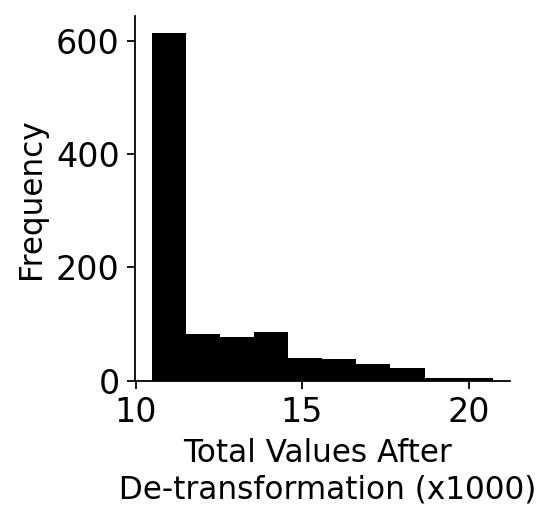

In [ ]:
smtx1=smtx2.copy()
smtx1.data=2**smtx1.data
histplot(smtx1.sum(axis=1)/1000,color="black",xl='Total Values After \n De-transformation (x1000)')#,save='figures/realdata/total_devalues.pdf')

### denorm

In [ ]:
ad.X=ad.layers['expr'].copy()

In [ ]:
smtx2=ad.X.copy()

In [ ]:
smtx2

<1000x36501 sparse matrix of type '<class 'numpy.float64'>'
	with 2173216 stored elements in Compressed Sparse Row format>

##### auto 1

In [ ]:
np.random.seed(0)
num=100
ress=[]
for _ in range(num):
    ys=[]
    for c_idx in np.random.choice(range(smtx2.shape[0]),min(smtx2.shape[0],100),replace=False):
        try:
            c = pd.Series(smtx2.getrow(c_idx).data)
            y = np.array(c.value_counts().sort_index().head(2).index)
            ys.append(y)
        except:
            print(c_idx)
    ys=np.array(ys)
    y1=ys[:,0]
    y2=ys[:,1]
    res = minimize(solve_bc, [20,1], method='L-BFGS-B', tol=1e-10,bounds=[(1.9, None), (1e-6, None)],args=(ys[:,0],ys[:,1]))
    ress.append([res.x[0],res.x[1],res.fun])

In [ ]:
ress=pd.DataFrame(ress,columns=['base','pseudo','loss'])

In [ ]:
ress.base.mean()

1.999999988785788

{'whiskers': [<matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>],
 'caps': [<matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>],
 'boxes': [<matplotlib.lines.Line2D>],
 'medians': [<matplotlib.lines.Line2D>],
 'fliers': [<matplotlib.lines.Line2D>],
 'means': []}

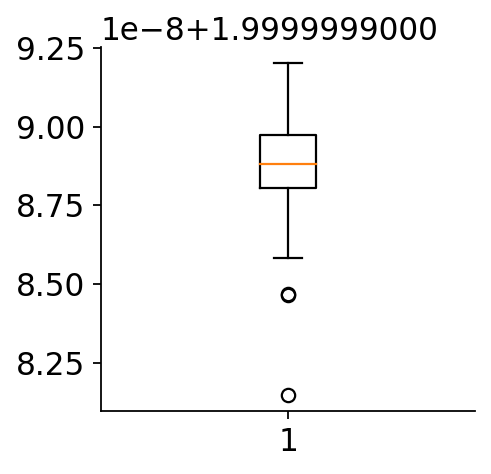

In [ ]:
plt.boxplot(ress.base)

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='base'>

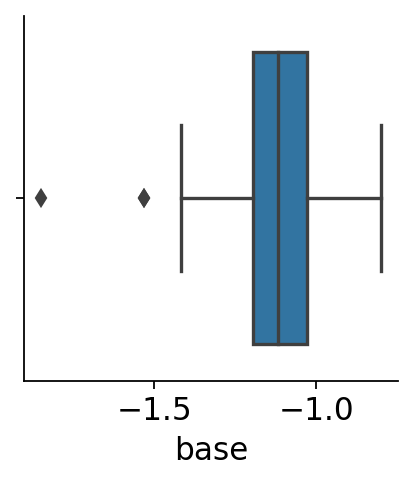

In [ ]:
sns.boxplot((ress.base-2)*10**8)

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pseudo'>

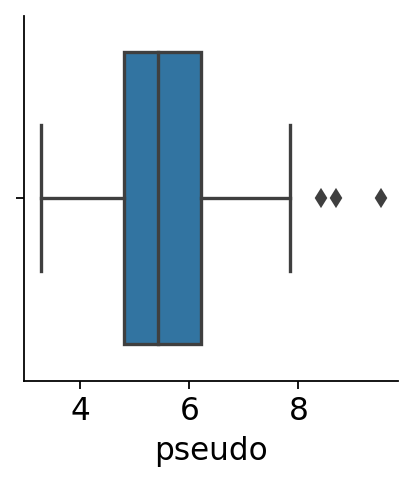

In [ ]:
sns.boxplot((ress.pseudo-1)*10**8)

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='loss'>

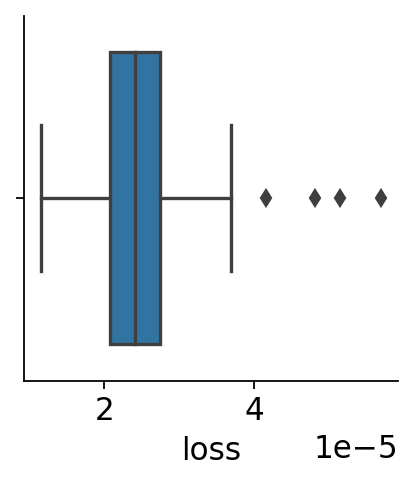

In [ ]:
sns.boxplot((ress.loss)*10**8)

### Fitted curve

In [89]:
np.random.seed(0)
ys=[]
for c_idx in np.random.choice(range(smtx2.shape[0]),min(smtx2.shape[0],100),replace=False):
    try:
        c = pd.Series(smtx2.getrow(c_idx).data)
        y = np.array(c.value_counts().sort_index().head(2).index)
        ys.append(y)
    except:
        print(c_idx)
ys=np.array(ys)
y1=ys[:,0]
y2=ys[:,1]
res = minimize(solve_bc, [20,1], method='L-BFGS-B', tol=1e-10,bounds=[(1.9, None), (1e-6, None)],args=(ys[:,0],ys[:,1]))

In [ ]:
"#4C72B0" (blue)
"#DD8452" (orange)
"#55A868" (green)
"#C44E52" (red)
"#8172B2" (purple)
"#937860" (brown)
"#DA8BC3" (pink)
"#8C8C8C" (gray)
"#CCB974" (yellow)
"#64B5CD" (turquoise)

In [90]:
res

      fun: 3.3796832057499985e-13
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([4.41920831e-09, 4.03474232e-09])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 153
      nit: 50
     njev: 51
   status: 0
  success: True
        x: array([1.99999999, 1.00000008])

In [91]:
def solve_bc(p,y1,y2):
    return sum((np.exp(y2*np.log(p[0]))-2*np.exp(y1*np.log(p[0]))+p[1])**2)

In [92]:
def predbybc(y1,base,cont):
    return np.log(2*np.exp(y1*np.log(base))-cont)/np.log(base)

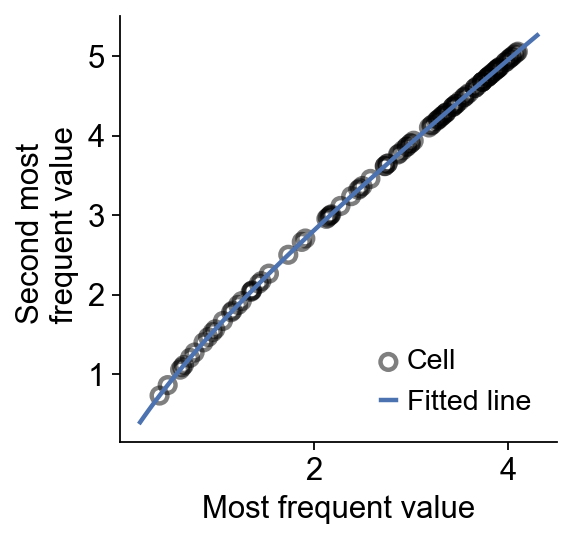

In [93]:
# generate some sample data
x = y1
y = y2

# fit a line to the data
x_new=np.linspace(min(x)-0.2,max(x)+0.2,num=100)
fitted_y = predbybc(x_new,res.x[0],res.x[1])
fig, ax = plt.subplots()
ax.scatter(x, y, s=50, alpha=0.5,facecolors='none',marker='o',label='Cell',linewidth=2,edgecolors='black')
ax.set_facecolor('none')
ax.plot(x_new, fitted_y, c='#4C72B0', label='Fitted line',linewidth=2)
plt.legend(loc='lower right', frameon=False)
plt.xlabel('Most frequent value')
plt.ylabel('Second most \n frequent value')
plt.savefig('figures/fitcurve.pdf',dpi=300, bbox_inches='tight',transparent=True,format='pdf')

# De-transform

In [85]:
smtx1=ad.layers['expr'].copy()
smtx1.data=2**smtx1.data
smtx1.data=smtx1.data-1

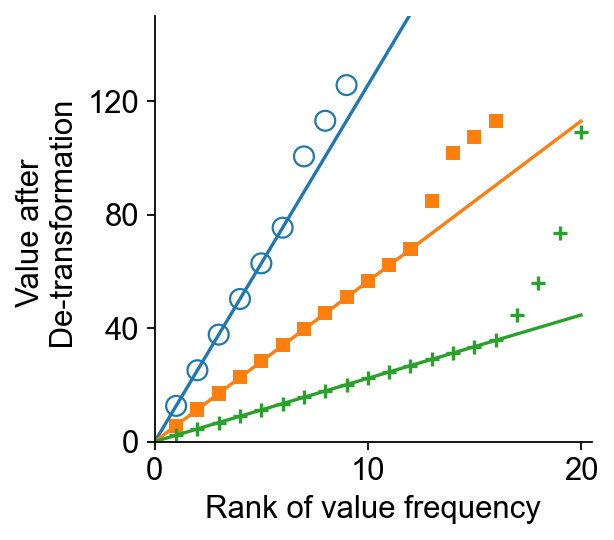

In [86]:
figsize(3.5,3.5)
tmp=smtx1.copy()
RCplot1(tmp,xm=20.5,ym=150,yl='Value after \n De-transformation',fit=True,show_legend=False)#,save='figures/rankvsexpr_detransform.pdf')

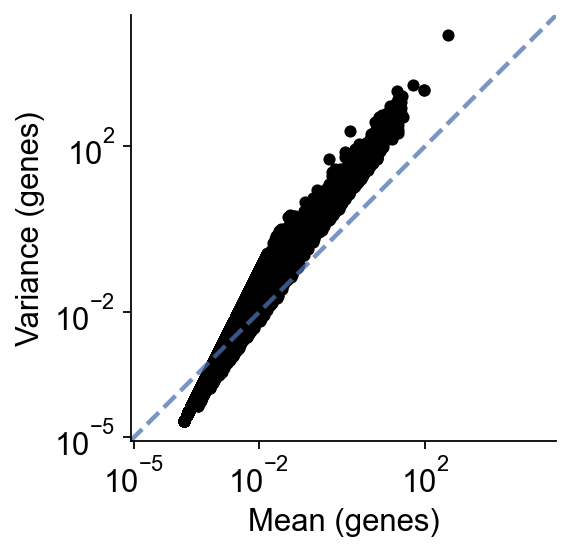

In [87]:
cmean = np.array(smtx1.mean(0))
cvar = np.array(smtx1.power(2).mean(0) - cmean ** 2)
#A
plot_mv(cmean,cvar,x_ticks=[0.00001,0.01,100],y_ticks=[0.00001,0.01,100],c='black',fit=False,log=True)#,save='figures/realdata/mvsv_expr.pdf')

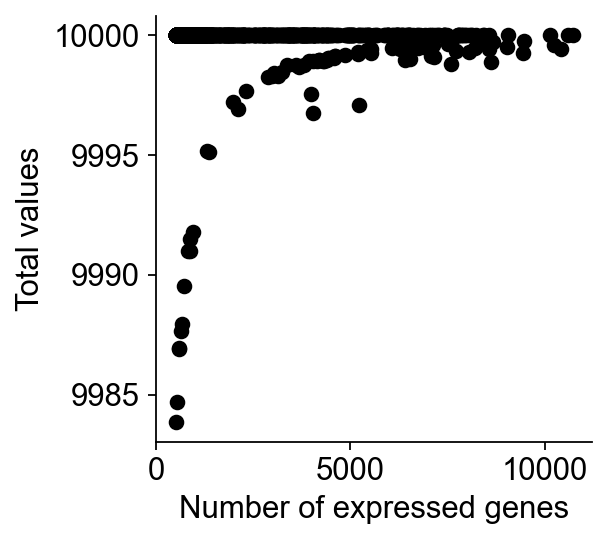

In [88]:
fig,ax=plt.subplots()
ax.plot((smtx1>0).sum(axis=1),smtx1.sum(axis=1),'o',c='black')
ax.spines[['right', 'top']].set_visible(False)
#ax.tick_params(axis='both', which='major', labelsize=15)
#ax.tick_params(axis='both', which='minor', labelsize=8)
ax.set_xlabel('Number of expressed genes')
ax.set_ylabel('Total values')
plt.savefig('figures/ng_vs_tnc.pdf',dpi=300, bbox_inches='tight',transparent=True,format='pdf')

### errors

In [94]:
np.random.seed(0)
num=100
ress=[]
for _ in range(num):
    ys=[]
    for c_idx in np.random.choice(range(smtx2.shape[0]),min(smtx2.shape[0],100),replace=False):
        try:
            c = pd.Series(smtx2.getrow(c_idx).data)
            y = np.array(c.value_counts().sort_index().head(2).index)
            ys.append(y)
        except:
            print(c_idx)
    ys=np.array(ys)
    y1=ys[:,0]
    y2=ys[:,1]
    res = minimize(solve_bc, [20,1], method='L-BFGS-B', tol=1e-10,bounds=[(1.9, None), (1e-6, None)],args=(ys[:,0],ys[:,1]))
    ress.append([res.x[0],res.x[1],res.fun])

In [95]:
ress=pd.DataFrame(ress,columns=['base','pseudo','loss'])

In [ ]:
ress.base.mean()

1.999999988785788

In [ ]:
ress.pseudo.mean()

1.0000000559615259

In [106]:
ad.X=ad.layers['expr'].copy()

In [107]:
ad1=scdenorm(ad,rint=False,base=ress.base.mean(),cont=ress.pseudo.mean())

100%|██████████| 1000/1000 [00:00<00:00, 1140.94it/s]


In [108]:
ad1.X.sort_indices()

In [109]:
ad1.X.data

array([1., 1., 1., ..., 2., 1., 2.])

In [110]:
ad2=ad.copy()
ad2.X=ad.layers['counts'].copy()

In [111]:
tmp2=ad1.X.copy()
tmp2.data=tmp2.data-ad2.X.data

In [112]:
tmp2.max()

0.000856448814374744

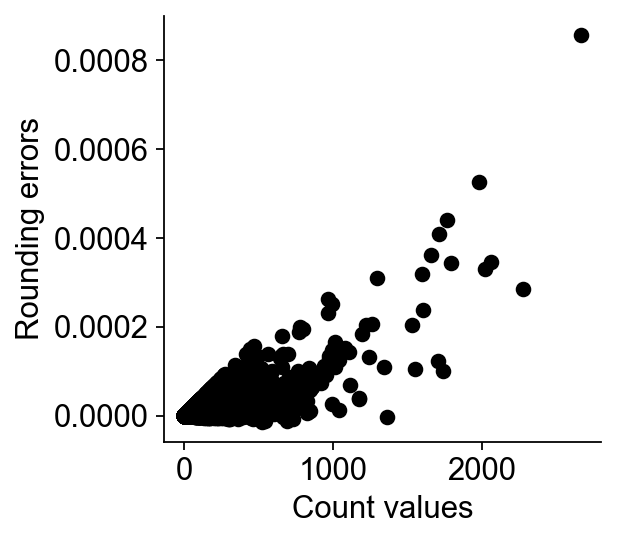

In [114]:
plt.plot(ad2.X.data,tmp2.data,'o',c='black')
plt.xlabel('Count values')
plt.ylabel('Rounding errors')
plt.savefig('figures/rounding_errors.pdf',dpi=300, bbox_inches='tight',transparent=True,format='pdf')